<h1> Deep Learning Model 6

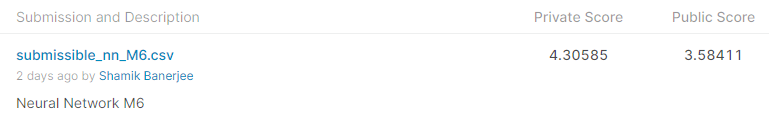

#### Installs and Imports

In [ ]:
# !wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.193 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en-GB;q=0.9,en-US;q=0.8,en;q=0.7" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/18599/1236839/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1605279325&Signature=T9NRy9SA1Wyg4nZaFs%2BmrVLXqoeGp2N3uwqbAhFYLPXt3a9O4aNHPHoYB13RkngLnX6QbWy3UDhe6obwcfIKu8HKn7RbuFK%2BRb7gY%2FWXBqAbzXvsxBLIoeI6hJv0trPXwCLo6m4766JIbxGdV3h1fatmEvaLoNezTTq2wvBazBUeMXRUw%2B%2BU1RrcAnwRkUkJuv2rdAX7nwERwnh%2BxFRvLcU%2F%2FYzCXIIdRRJqISOuUHCKenwEhLGZ47XLF%2FLdS8B39qjDkYqp52Fgjuae%2FieJKy8sXWNNAneP%2FRAbVsD3smQqkKkv05Bp3fmkYMQEWmEc5T4eVVXg%2BqAb5ysmX%2FQe7Q%3D%3D&response-content-disposition=attachment%3B+filename%3Dm5-forecasting-accuracy.zip" -c -O 'm5-forecasting-accuracy.zip'

In [ ]:
# !unzip m5-forecasting-accuracy.zip

# !apt-get update
# !apt-get install wget

# ! pip install pandas
# ! pip install calender
# ! pip install numpy
# ! pip install datetime
# ! pip install matplotlib
# ! pip install collections
# ! pip install random
# ! pip install tqdm
# ! pip install sklearn
# ! pip install lightgbm

In [3]:
from IPython.display import clear_output 
import pandas as pd
import calendar
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output as cclear
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
import joblib
# import xgboost as xgb
from tensorflow.keras import backend as K 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras import activations

#### Functions

In [ ]:
def get_csv(X):
    return pd.read_csv(X)

calender, sales_train_ev, sales_train_val, sell_prices, samp_sub = get_csv('calendar.csv'), \
                          get_csv('sales_train_evaluation.csv'), \
                          get_csv('sales_train_validation.csv'), get_csv('sell_prices.csv'), \
                          get_csv('sample_submission.csv')

non_numeric_col_list = ['id','item_id','dept_id','cat_id','store_id','state_id','d', 'date']
store_dict = {'CA_1':0, 'CA_2':0, 'CA_3':0, 'CA_4':0, 'WI_1':0, 'WI_2':0, 'WI_3':0, 'TX_1':0, 'TX_2':0, 'TX_3':0}

# This function does feature engineering on sales_train_ev or sales_train_val
# There is another feature engineering function for adding columns to dataframe containing rows of only onw store
def feature_engineer(df):
    day_columns = list(df.columns[6:])
    other_var = list(df.columns[:6])
    
    df = pd.melt(df, id_vars = other_var, value_vars = day_columns)
    df = df.rename(columns = {"variable": "d", "value": "unit_sale"})
    # print(df.shape)

    cal_dict = dict(zip(calender.d,calender.date))
    df["date"] = df["d"].map(cal_dict)
    # df.head()
    
    day_of_week_dict = dict(zip(calender.d,calender.wday))
    df['day_of_week'] = df["d"].map(day_of_week_dict)

    month_no_dict = dict(zip(calender.d,calender.month))
    df['month_no'] = df["d"].map(month_no_dict)

    l = [i[-2:] for i in list(calender.date)]
    calender['day_of_month'] = l

    day_of_month_dict = dict(zip(calender.d,calender.day_of_month))
    df['day_of_month'] = df["d"].map(day_of_month_dict)
    return df

def add_moving_avg_col(new_df,N, col_name):
    l = np.convolve(list(new_df[col_name]), np.ones((N,))/N, mode='valid')
    nl = [0]*(N-1)
    nl.extend(list(l))
    new_df[str(N)+'_d_mavg_'+str(col_name)] = nl
    return new_df


def event1_check(index):
    # Input is 0 to 1968, it is the index of Calender.CSV
    # Output is True if there is event 1, False if no event 1
    return not(calender.event_name_1[index] != calender.event_name_1[index])

def event2_check(index):
    # Input is 0 to 1968, it is the index of Calender.CSV
    # Output is True if there is event 2, False if no event 2
    return not(calender.event_name_2[index] != calender.event_name_2[index])

days_with_event = []
for i in range(len(calender)):
    days_with_event.append(event1_check(i)) or (event2_check(i))
    
l = [int(i) for i in days_with_event]
event_dict = dict(zip(calender.d, l))

week_no_d_dict = dict(zip(calender.wm_yr_wk, calender.d))
sell_prices['d'] = sell_prices['wm_yr_wk'].map(week_no_d_dict)
sell_prices['item_d_col'] = sell_prices['item_id'] + sell_prices['d']
sale_price_dict = dict(zip(sell_prices['item_d_col'], sell_prices['sell_price']))

sell_prices = sell_prices.drop('d', 1)
sell_prices = sell_prices.drop('item_d_col', 1)


def one_feature_engineering_fun(df):
    snap_dict = dict(zip(calender.d, calender['snap_'+df.state_id.iloc[0]]))   # Add snap or not column
    df['snap_or_not'] = df["d"].map(snap_dict)
    print('snap added')
    
    df['event_or_not'] = df["d"].map(event_dict)    # Adding event or not column
    print('events added')
    
    df['item_d_col'] = df['item_id'] + df['d']      # Adding sale_price column
    df['sale_price'] = df['item_d_col'].map(sale_price_dict)
    df['sale_price'] = df['sale_price'].fillna(0)
    print('sale prices added')
    
    df = df.drop('item_d_col', 1)                   # Undoing the columns we had to add
    
    df['Total_sale'] = df.unit_sale * df.sale_price  # Adding total sale column
    
    df = add_moving_avg_col(df,7, 'sale_price')     # Adding moving averages for sale price
    df = add_moving_avg_col(df,14, 'sale_price')
    df = add_moving_avg_col(df,30, 'sale_price')
    df = add_moving_avg_col(df,60, 'sale_price')
    df = add_moving_avg_col(df,180, 'sale_price')
                 
    df['day_of_month'] = df['day_of_month'].fillna(0)
    df = df.astype({'day_of_month': 'int32'})      # Making day_of_month column as int
    
    df['date'] = df['date'].astype(str)
    
    df = add_moving_avg_col(df,7, 'unit_sale')     # Adding moving average columns
    df = add_moving_avg_col(df,14, 'unit_sale')
    df = add_moving_avg_col(df,30, 'unit_sale')
    df = add_moving_avg_col(df,60, 'unit_sale')
    df = add_moving_avg_col(df,180, 'unit_sale')
    print('Total sale and Unit sale moving averages added')
    
    l1 = df.day_of_week == 1                       # we are adding an weekend or not column
    l2 = df.day_of_week == 2

    l1 = np.logical_or(l1,l2)
    l1 = [elem*1 for elem in l1]
    df['weekend'] = l1
    print('Weekends added')
    
    return df


def encode_cat_cols(new_df):
    le = [0]*len(non_numeric_col_list)             # Encoding Categorical Columns
    for i in range(len(non_numeric_col_list)):
        print("Encoding col: ", non_numeric_col_list[i])
        le[i] = LabelEncoder()
        new_df[non_numeric_col_list[i]] = le[i].fit_transform( new_df[non_numeric_col_list[i]] )
    return le, new_df

# This function takes sales_train_ev or sales_train_val after feature_engineer() function has been called on them
# and returns X, y and labelencoder after adding few more columns and encoding categorical features.
def get_X_and_y(df, store_name):               
    print('Store Name:', store_name)
    new_df = df[df.store_id == store_name]        # Selecting rows for the selected store
    
    print('Store rows picked now working on adding columns...')
    new_df = one_feature_engineering_fun(new_df)     # working on adding more columns and changing datatype of columns
    
    y = new_df.unit_sale                          # getting the label
    new_df = new_df.drop('unit_sale', axis=1)
    
    print('Encoding categorical features...')
    le, new_df = encode_cat_cols(new_df)          # Encoding Categorical Columns

    X = new_df
    
    return X, y, le

def reverse_long_form(le, X_test, train_out):
    for i in range(len(non_numeric_col_list)):
        X_test[non_numeric_col_list[i]] = le[i].inverse_transform(X_test[non_numeric_col_list[i]])

    X_test['unit_sale'] = train_out
    kk = X_test.pivot(index='id', columns='d')['unit_sale']
    kk['id'] = kk.index
    kk.reset_index(drop=True, inplace=True)

    cols = list(kk)
    cols = [cols[-1]] + cols[:-1]
    kk = kk[cols]
    
    return kk


def get_train_test(new_df, dept):
    evaluation, validation = new_df.id.iloc[0].find('evaluation'), new_df.id.iloc[0].find('validation')
    print('Picking rows for dept ', dept, '...')
    new_df = new_df[new_df.dept_id == dept]

    print('Total rows: ', len(new_df))
    rows_per_day = len(new_df[new_df.d == 'd_1'])
    print('Rows per day: ', rows_per_day)

    new_df = one_feature_engineering_fun(new_df)

    y = new_df.unit_sale                          # getting the label
    new_df = new_df.drop('unit_sale', axis=1)

    print('Encoding categorical features...')
    le, new_df = encode_cat_cols(new_df)          # Encoding Categorical Columns

    X = new_df

    ev_train_start, ev_train_end, val_train_start, val_train_end = rows_per_day*(0), rows_per_day*1941,\
                                                                       rows_per_day*(0), rows_per_day*1913

    if evaluation != -1:  # if evaluation data
        print('Getting X_train, y_train...')
        # fitiing only on one year data
        X_train, y_train = X.iloc[ev_train_start:ev_train_end], y[ev_train_start:ev_train_end] 
        X_test, y_test = X.iloc[ev_train_end:], y[ev_train_end:] 

    if validation != -1:  # if validation data
        print('Getting X_train, y_train...')
        X_train, y_train = X.iloc[val_train_start:val_train_end], y[val_train_start:val_train_end]
        X_test, y_test = X.iloc[val_train_end:], y[val_train_end:]

    cclear()
    print('X_train len', len(X_train), 'y_train len', len(y_train), 'X_test len', len(X_test))
    print('Done.')
    return le, X_train, y_train, X_test

class terminate_on_acc(tf.keras.callbacks.Callback):    
    def on_epoch_end(self, epoch, logs={}):
        loss = logs['loss']
        if loss < target_loss:
            self.model.stop_training = True
terminate_on_acc = terminate_on_acc()

def train_NN(X_train, y_train, X_test, epoch_no, model_name, model):
    
    print('Shaping data for Neural Network...')
    X_train, y_train, X_test = np.matrix(X_train).astype(np.float32), np.matrix(y_train).astype(np.float32),\
                               np.matrix(X_test).astype(np.float32)
    X_train, y_train = tf.convert_to_tensor(X_train), tf.convert_to_tensor(y_train)
    X_test = tf.convert_to_tensor(X_test)
    y_train = tf.reshape(y_train, shape = (np.shape(X_train)[0], 1))
    
    checkpoint = ModelCheckpoint(filepath='model_'+str(model_name)+'.h5', monitor='loss', verbose=1, 
                                 save_best_only=True, mode='auto')

    model.fit(X_train, y_train, epochs=epoch_no, verbose=1, callbacks = [terminate_on_acc, checkpoint])
    print('Just making the predictions...')
    y_hat = model.predict(X_test)
    print('Done.')
    
    return y_hat


def predict_dept(df, dept_name, model, epoch_no):
    evaluation, validation = df.id.iloc[0].find('evaluation'), df.id.iloc[0].find('validation')
    
    le, X_train, y_train, X_test = get_train_test(df, dept_name)
    
    if evaluation != -1:  # if evaluation data
        y_hat = train_NN(X_train, y_train, X_test, epoch_no, str(dept_name)+'_M6_ev', model)
    if validation != -1:  # if validation data
        y_hat = train_NN(X_train, y_train, X_test, epoch_no, str(dept_name)+'_M6_val', model)
    
    print('Reversing the long form...')
    out_df = reverse_long_form(le, X_test, y_hat)
    out_df = pd.DataFrame(out_df)

    l = []      # In this part we rename the columns to F_1, F_2 ....
    for i in range(1,29):
        l.append('F'+str(i))
    l = ['id']+l
    
    print('Writing the output to CSV...')
    out_df.columns = l
    if evaluation != -1:  # if evaluation data
        out_df.to_csv(str(dept_name)+'_M6_ev.csv', index=False)
    if validation != -1:  # if validation data
        out_df.to_csv(str(dept_name)+'_M6_val.csv', index=False)
    print('Done.')

In [ ]:
#####################################################################################################################

#### Training for Evaluation Data

In [2]:
%%time
print('Preparing Evaluation CSV...')
df = sales_train_ev.copy()
empty_list = [0]*30490
for i in range(1942, 1970):
    df['d_'+str(i)] = empty_list
df = feature_engineer(df)

Preparing Evaluation CSV...
CPU times: user 34.6 s, sys: 9.07 s, total: 43.6 s
Wall time: 43.5 s


In [3]:
set(df.dept_id)

{'FOODS_1',
 'FOODS_2',
 'FOODS_3',
 'HOBBIES_1',
 'HOBBIES_2',
 'HOUSEHOLD_1',
 'HOUSEHOLD_2'}

In [ ]:
# We can fit the same model to all stores sequentially without recompliling everytime, that can be an experiemnt.

In [4]:
%%time
target_loss = 0.7

model = Sequential()        
model.add(Dense(75, activation='relu', input_shape=(26,)))
model.add(Dense(150))
model.add(Dense(250))
model.add(Dense(120))
model.add(Dense(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

CPU times: user 442 ms, sys: 239 ms, total: 681 ms
Wall time: 694 ms


In [15]:
# %%time
# model.compile(optimizer='adam', loss='mse')
# predict_dept(df, 'HOBBIES_1', model, 4)

X_train len 8074560 y_train len 8074560 X_test len 116480
Done.
Shaping data for Neural Network...
Train on 8074560 samples
Epoch 1/4
8073952/8074560 [============================>.] - ETA: 0s - loss: 26.9072
Epoch 00001: loss improved from inf to 26.90553, saving model to model_HOBBIES_1_M6_ev.h5
8074560/8074560 [==============================] - 505s 62us/sample - loss: 26.9055
Epoch 2/4
8073952/8074560 [============================>.] - ETA: 0s - loss: 5.3610
Epoch 00002: loss improved from 26.90553 to 5.36108, saving model to model_HOBBIES_1_M6_ev.h5
8074560/8074560 [==============================] - 502s 62us/sample - loss: 5.3611
Epoch 3/4
8073888/8074560 [============================>.] - ETA: 0s - loss: 5.3612
Epoch 00003: loss improved from 5.36108 to 5.36106, saving model to model_HOBBIES_1_M6_ev.h5
8074560/8074560 [==============================] - 502s 62us/sample - loss: 5.3611
Epoch 4/4
8074368/8074560 [============================>.] - ETA: 0s - loss: 5.3613
Epoch 00004:

In [16]:
# %%time
# model.compile(optimizer='adam', loss='mse')
# predict_dept(df, 'HOBBIES_2', model, 4)

X_train len 2892090 y_train len 2892090 X_test len 41720
Done.
Shaping data for Neural Network...
Train on 2892090 samples
Epoch 1/4
2891552/2892090 [============================>.] - ETA: 0s - loss: 0.5697
Epoch 00001: loss improved from inf to 0.56964, saving model to model_HOBBIES_2_M6_ev.h5
2892090/2892090 [==============================] - 215s 74us/sample - loss: 0.5696
Just making the predictions...
Done.
Reversing the long form...
Writing the output to CSV...
Done.
CPU times: user 5min 36s, sys: 37.1 s, total: 6min 13s
Wall time: 4min 1s


In [17]:
# %%time
# model.compile(optimizer='adam', loss='mse')
# predict_dept(df, 'HOUSEHOLD_1', model, 4)

X_train len 10326120 y_train len 10326120 X_test len 148960
Done.
Shaping data for Neural Network...
Train on 10326120 samples
Epoch 1/4
10325984/10326120 [============================>.] - ETA: 0s - loss: 6.8591
Epoch 00001: loss improved from inf to 6.85908, saving model to model_HOUSEHOLD_1_M6_ev.h5
10326120/10326120 [==============================] - 766s 74us/sample - loss: 6.8591
Epoch 2/4
10325856/10326120 [============================>.] - ETA: 0s - loss: 6.2420
Epoch 00002: loss improved from 6.85908 to 6.24192, saving model to model_HOUSEHOLD_1_M6_ev.h5
10326120/10326120 [==============================] - 767s 74us/sample - loss: 6.2419
Epoch 3/4
10325984/10326120 [============================>.] - ETA: 0s - loss: 6.1615
Epoch 00003: loss improved from 6.24192 to 6.16147, saving model to model_HOUSEHOLD_1_M6_ev.h5
10326120/10326120 [==============================] - 766s 74us/sample - loss: 6.1615
Epoch 4/4
10326048/10326120 [============================>.] - ETA: 0s - loss: 

In [18]:
# %%time
# model.compile(optimizer='adam', loss='mse')
# predict_dept(df, 'HOUSEHOLD_2', model, 4)

X_train len 9996150 y_train len 9996150 X_test len 144200
Done.
Shaping data for Neural Network...
Train on 9996150 samples
Epoch 1/4
9995968/9996150 [============================>.] - ETA: 0s - loss: 0.5549
Epoch 00001: loss improved from inf to 0.55485, saving model to model_HOUSEHOLD_2_M6_ev.h5
9996150/9996150 [==============================] - 743s 74us/sample - loss: 0.5549
Just making the predictions...
Done.
Reversing the long form...
Writing the output to CSV...
Done.
CPU times: user 19min 11s, sys: 2min 15s, total: 21min 27s
Wall time: 13min 50s


In [3]:
%%time
target_loss = 9

model = Sequential()        
model.add(Dense(75, activation='relu', input_shape=(26,)))
model.add(Dense(150))
model.add(Dense(150))
model.add(Dense(120))
model.add(Dense(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
predict_dept(df, 'FOODS_1', model, 3)

X_train len 4192560 y_train len 4192560 X_test len 60480
Done.
Shaping data for Neural Network...
Train on 4192560 samples
Epoch 1/3
4192224/4192560 [============================>.] - ETA: 0s - loss: 18.7905
Epoch 00001: loss improved from inf to 18.78930, saving model to model_FOODS_1_M6_ev.h5
4192560/4192560 [==============================] - 557s 133us/sample - loss: 18.7893
Epoch 2/3
4192544/4192560 [============================>.] - ETA: 0s - loss: 7.0608
Epoch 00002: loss improved from 18.78930 to 7.06076, saving model to model_FOODS_1_M6_ev.h5
4192560/4192560 [==============================] - 558s 133us/sample - loss: 7.0608
Just making the predictions...
Done.
Reversing the long form...
Writing the output to CSV...
Done.
CPU times: user 25min 52s, sys: 3min 4s, total: 28min 57s
Wall time: 19min 37s


In [5]:
%%time
target_loss = 0.7

model = Sequential()        
model.add(Dense(75, activation='relu', input_shape=(26,)))
model.add(Dense(150))
model.add(Dense(150))
model.add(Dense(50))
model.add(Dense(20))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

predict_dept(df, 'FOODS_2', model, 4)

X_train len 7725180 y_train len 7725180 X_test len 111440
Done.
Shaping data for Neural Network...
Train on 7725180 samples
Epoch 1/4
7724864/7725180 [============================>.] - ETA: 0s - loss: 26.7001
Epoch 00001: loss improved from inf to 26.69927, saving model to model_FOODS_2_M6_ev.h5
7725180/7725180 [==============================] - 999s 129us/sample - loss: 26.6993
Epoch 2/4
7724768/7725180 [============================>.] - ETA: 0s - loss: 5.6448
Epoch 00002: loss improved from 26.69927 to 5.64486, saving model to model_FOODS_2_M6_ev.h5
7725180/7725180 [==============================] - 999s 129us/sample - loss: 5.6449
Epoch 3/4
7724896/7725180 [============================>.] - ETA: 0s - loss: 5.5973
Epoch 00003: loss improved from 5.64486 to 5.59722, saving model to model_FOODS_2_M6_ev.h5
7725180/7725180 [==============================] - 998s 129us/sample - loss: 5.5972
Epoch 4/4
7725120/7725180 [============================>.] - ETA: 0s - loss: 5.5742
Epoch 00004: lo

In [ ]:
# %%time
# model.compile(optimizer='adam', loss='mse')
# predict_dept(df, 'FOODS_3', model, 4)

#### Training for Validation Data

In [21]:
%%time
df = sales_train_val.copy()
empty_list = [0]*30490
for i in range(1914, 1942):
    df['d_'+str(i)] = empty_list
df = feature_engineer(df)

CPU times: user 29.5 s, sys: 9.02 s, total: 38.5 s
Wall time: 38.4 s


In [22]:
set(df.dept_id)

{'FOODS_1',
 'FOODS_2',
 'FOODS_3',
 'HOBBIES_1',
 'HOBBIES_2',
 'HOUSEHOLD_1',
 'HOUSEHOLD_2'}

In [23]:
%%time
target_loss = 0.7

model = Sequential()        
model.add(Dense(75, activation='relu', input_shape=(26,)))
model.add(Dense(150))
model.add(Dense(250))
model.add(Dense(120))
model.add(Dense(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

CPU times: user 75.5 ms, sys: 0 ns, total: 75.5 ms
Wall time: 72.3 ms


In [24]:
%%time
model.compile(optimizer='adam', loss='mse')
predict_dept(df, 'HOBBIES_1', model, 4)

X_train len 7958080 y_train len 7958080 X_test len 116480
Done.
Shaping data for Neural Network...
Train on 7958080 samples
Epoch 1/4
7957440/7958080 [============================>.] - ETA: 0s - loss: 32.5441
Epoch 00001: loss improved from inf to 32.54179, saving model to model_HOBBIES_1_M6_val.h5
7958080/7958080 [==============================] - 496s 62us/sample - loss: 32.5418
Epoch 2/4
7957312/7958080 [============================>.] - ETA: 0s - loss: 5.3768
Epoch 00002: loss improved from 32.54179 to 5.37663, saving model to model_HOBBIES_1_M6_val.h5
7958080/7958080 [==============================] - 497s 62us/sample - loss: 5.3766
Epoch 3/4
7958016/7958080 [============================>.] - ETA: 0s - loss: 5.3609
Epoch 00003: loss improved from 5.37663 to 5.36083, saving model to model_HOBBIES_1_M6_val.h5
7958080/7958080 [==============================] - 496s 62us/sample - loss: 5.3608
Epoch 4/4
7957600/7958080 [============================>.] - ETA: 0s - loss: 5.5660
Epoch 000

In [25]:
%%time
model.compile(optimizer='adam', loss='mse')
predict_dept(df, 'HOBBIES_2', model, 4)

X_train len 2850370 y_train len 2850370 X_test len 41720
Done.
Shaping data for Neural Network...
Train on 2850370 samples
Epoch 1/4
2850304/2850370 [============================>.] - ETA: 0s - loss: 0.5657
Epoch 00001: loss improved from inf to 0.56571, saving model to model_HOBBIES_2_M6_val.h5
2850370/2850370 [==============================] - 213s 75us/sample - loss: 0.5657
Just making the predictions...
Done.
Reversing the long form...
Writing the output to CSV...
Done.
CPU times: user 5min 31s, sys: 36.3 s, total: 6min 8s
Wall time: 3min 58s


In [26]:
%%time
target_loss = 0.7

model = Sequential()        
model.add(Dense(75, activation='relu', input_shape=(26,)))
model.add(Dense(150))
model.add(Dense(150))
model.add(Dense(120))
model.add(Dense(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
predict_dept(df, 'HOUSEHOLD_1', model, 3)

X_train len 10177160 y_train len 10177160 X_test len 148960
Done.
Shaping data for Neural Network...
Train on 10177160 samples
Epoch 1/4
10176576/10177160 [============================>.] - ETA: 0s - loss: 7.5644
Epoch 00001: loss improved from inf to 7.56468, saving model to model_HOUSEHOLD_1_M6_val.h5
10177160/10177160 [==============================] - 758s 74us/sample - loss: 7.5647
Epoch 2/4
10176704/10177160 [============================>.] - ETA: 0s - loss: 7.5636
Epoch 00002: loss improved from 7.56468 to 7.56354, saving model to model_HOUSEHOLD_1_M6_val.h5
10177160/10177160 [==============================] - 757s 74us/sample - loss: 7.5635
Epoch 3/4
10176672/10177160 [============================>.] - ETA: 0s - loss: 7.5637
Epoch 00003: loss did not improve from 7.56354
10177160/10177160 [==============================] - 759s 75us/sample - loss: 7.5636
Epoch 4/4
10176896/10177160 [============================>.] - ETA: 0s - loss: 7.5634
Epoch 00004: loss did not improve from 

In [27]:
# %%time
# model.compile(optimizer='adam', loss='mse')
# predict_dept(df, 'HOUSEHOLD_2', model, 4)

X_train len 9851950 y_train len 9851950 X_test len 144200
Done.
Shaping data for Neural Network...
Train on 9851950 samples
Epoch 1/4
9851520/9851950 [============================>.] - ETA: 0s - loss: 0.6896
Epoch 00001: loss improved from inf to 0.68960, saving model to model_HOUSEHOLD_2_M6_val.h5
9851950/9851950 [==============================] - 730s 74us/sample - loss: 0.6896
Just making the predictions...
Done.
Reversing the long form...
Writing the output to CSV...
Done.
CPU times: user 18min 50s, sys: 2min 13s, total: 21min 4s
Wall time: 13min 35s


In [28]:
%%%%time
target_loss = 0.7

model = Sequential()        
model.add(Dense(75, activation='relu', input_shape=(26,)))
model.add(Dense(150))
model.add(Dense(150))
model.add(Dense(120))
model.add(Dense(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

predict_dept(df, 'FOODS_1', model, 3)

X_train len 4132080 y_train len 4132080 X_test len 60480
Done.
Shaping data for Neural Network...
Train on 4132080 samples
Epoch 1/4
4131616/4132080 [============================>.] - ETA: 0s - loss: 9.3012
Epoch 00001: loss improved from inf to 9.30115, saving model to model_FOODS_1_M6_val.h5
4132080/4132080 [==============================] - 308s 75us/sample - loss: 9.3012
Epoch 2/4
4131776/4132080 [============================>.] - ETA: 0s - loss: 9.2947
Epoch 00002: loss improved from 9.30115 to 9.29460, saving model to model_FOODS_1_M6_val.h5
4132080/4132080 [==============================] - 307s 74us/sample - loss: 9.2946
Epoch 3/4
4131456/4132080 [============================>.] - ETA: 0s - loss: 9.2949
Epoch 00003: loss improved from 9.29460 to 9.29451, saving model to model_FOODS_1_M6_val.h5
4132080/4132080 [==============================] - 307s 74us/sample - loss: 9.2945
Epoch 4/4
4131808/4132080 [============================>.] - ETA: 0s - loss: 9.2945
Epoch 00004: loss di

In [ ]:
%%time
target_loss = 0.7

model = Sequential()        
model.add(Dense(75, activation='relu', input_shape=(26,)))
model.add(Dense(150))
model.add(Dense(250))
model.add(Dense(120))
model.add(Dense(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
predict_dept(df, 'FOODS_2', model, 3)

X_train len 7613740 y_train len 7613740 X_test len 111440
Done.
Shaping data for Neural Network...
Train on 7613740 samples
Epoch 1/4
7613312/7613740 [============================>.] - ETA: 0s - loss: 7.2465
Epoch 00001: loss improved from inf to 7.24645, saving model to model_FOODS_2_M6_val.h5
7613740/7613740 [==============================] - 566s 74us/sample - loss: 7.2465
Epoch 2/4
7613664/7613740 [============================>.] - ETA: 0s - loss: 7.2472
Epoch 00002: loss did not improve from 7.24645
7613740/7613740 [==============================] - 567s 74us/sample - loss: 7.2472
Epoch 3/4
7613440/7613740 [============================>.] - ETA: 0s - loss: 7.2462
Epoch 00003: loss improved from 7.24645 to 7.24640, saving model to model_FOODS_2_M6_val.h5
7613740/7613740 [==============================] - 566s 74us/sample - loss: 7.2464
Epoch 4/4
7054048/7613740 [==========================>...] - ETA: 41s - loss: 7.2673

In [ ]:
# %%time
# model.compile(optimizer='adam', loss='mse')
# predict_dept(df, 'FOODS_3', model, 4)

#### Merging and Making Submissible CSV ###############################################

In [5]:
path = 'C:/Users/iamsh/Desktop/CS1 Kaggle Files/DL/M6/'

In [6]:
def fun(name):
    return pd.read_csv(path+name+'.csv')

food1ev, food2ev, food3ev = fun('FOODS_1_M6_ev'), fun('FOODS_2_M6_ev'), fun('FOODS_3_M6_ev')
hobbies1ev, hobbies2ev = fun('HOBBIES_1_M6_ev'), fun('HOBBIES_2_M6_ev')
house1ev, house2ev = fun('HOUSEHOLD_1_M6_ev'), fun('HOUSEHOLD_2_M6_ev')

food1val, food2val, food3val = fun('FOODS_1_M6_val'), fun('FOODS_2_M6_val'), fun('FOODS_3_M6_val')
hobbies1val, hobbies2val = fun('HOBBIES_1_M6_val'), fun('HOBBIES_2_M6_val')
house1val, house2val = fun('HOUSEHOLD_1_M6_val'), fun('HOUSEHOLD_2_M6_val')

In [7]:
main_out_df_ev = pd.concat([food1ev, food2ev, food3ev, hobbies1ev, hobbies2ev, house1ev, house2ev], 
                           ignore_index=False)
main_out_df_val = pd.concat([food1val, food2val, food3val, hobbies1val, hobbies2val, house1val, house2val],
                            ignore_index=False)

In [8]:
def reorder(df, main_out):
    df['sp_index'] = (df.index)
    index_dict = dict(zip(df.id, df.sp_index))
    df = df.drop('sp_index', axis=1)
    main_out['sp_index'] = main_out["id"].map(index_dict)
    main_out = main_out.sort_values(by='sp_index', axis=0)
    main_out = main_out.drop('sp_index', axis=1)
    return main_out

In [9]:
out_1 = reorder(pd.read_csv('C:/Users/iamsh/Desktop/CS1 Kaggle Files/Given Files/sales_train_evaluation.csv'), main_out_df_ev)
out_2 = reorder(pd.read_csv('C:/Users/iamsh/Desktop/CS1 Kaggle Files/Given Files/sales_train_validation.csv'), main_out_df_val)

In [10]:
df = pd.concat([out_1, out_2], ignore_index=False)
df = df.round(2)
df.to_csv('submissible_nn_M6.csv', index=False)

In [11]:
pd.read_csv('submissible_nn_M6.csv')

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_evaluation,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,...,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71
1,HOBBIES_1_002_CA_1_evaluation,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,...,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71
2,HOBBIES_1_003_CA_1_evaluation,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,...,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71
3,HOBBIES_1_004_CA_1_evaluation,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,...,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71
4,HOBBIES_1_005_CA_1_evaluation,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,...,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_validation,0.08,0.07,0.06,0.05,-1.40,0.19,0.14,0.05,0.04,...,-1.43,0.10,0.09,0.06,0.05,0.04,0.03,-1.43,0.11,0.10
60976,FOODS_3_824_WI_3_validation,0.08,0.07,0.06,0.05,-1.21,0.19,0.14,0.05,0.04,...,-1.24,0.10,0.09,0.06,0.05,0.04,0.03,-1.23,0.11,0.10
60977,FOODS_3_825_WI_3_validation,0.08,0.07,0.06,0.05,-1.81,0.19,0.14,0.05,0.04,...,-1.84,0.10,0.09,0.06,0.05,0.04,0.03,-1.84,0.11,0.10
60978,FOODS_3_826_WI_3_validation,0.09,0.08,0.07,0.06,-0.71,0.19,0.15,0.05,0.04,...,-0.74,0.10,0.09,0.06,0.05,0.04,0.03,-0.73,0.11,0.10


In [ ]:
###############################################################################################################################

In [ ]:
# Models I tried and their loss values by epoch
# model = Sequential()        
# model.add(Dense(5, activation='relu', input_shape=(26,)))
# model.add(Dense(50))
# model.add(Dense(10))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')

# epoch 1 loss 7 
###################################################
# target_loss = 0.7

# model = Sequential()        
# model.add(Dense(50, activation='relu', input_shape=(26,)))
# model.add(Dense(250))
# model.add(Dense(500))
# model.add(Dense(250))
# model.add(Dense(50))
# model.add(Dense(10))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')

# y_hat = train_NN(X_train, y_train, X_test, 100, 'HOBBIES_1_ev', model)

# # Epoch 5, loss 5.36
####################################################
# target_loss = 0.7

# model = Sequential()        
# model.add(Dense(10, activation='relu', input_shape=(26,)))
# model.add(Dense(150))
# model.add(Dense(150))
# model.add(Dense(50))
# model.add(Dense(10))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')

# y_hat = train_NN(X_train, y_train, X_test, 50, 'HOBBIES_1_ev', model)
# Epoch 4, loss 4.5
###########################################
# target_loss = 0.7

# model = Sequential()        
# model.add(Dense(75, activation='relu', input_shape=(26,)))
# model.add(Dense(150))
# model.add(Dense(150))
# model.add(Dense(75))
# model.add(Dense(25))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')

# y_hat = train_NN(X_train, y_train, X_test, 50, 'HOBBIES_1_ev', model)
# e 5, l 4.3